# Chapter 2: End-to-End machine learning project
**Goal** Create a model to predict the median housing price in any district, given al the other metrics
**Data** California Housing Prices 

## Framing the problem
It is supervised learning since we have a dataset to train our model upon. It is a regression task, since we have to give a continuos estimate of the median housing price of any district. It is also a batched problem, since we train our model once and then we use it

## Select a performance measure
We have to give ourselves a way of knowing how well we are doing our job. For doing this we set a loss function that depends upon he data we're dealing with. In general we use norms as preferred loss functions, since they're easy to intepret and computationally efficient. 

The idea is that we want to measure how 'far' the model prediction (given all the features we have) is from the label (that we want to predict)

Norms are defined by an index, the l_2 norm corresponds to the Euclidean norm, the l_1 to the Manhattan norm. In general we denote the l_k norm as the k-th norm. The higher the index k goes, the more sensible our loss function will be to big values (outliers) within the data. 


## Get the data 
First of all we have to actually get the data into our virtual enviroment 

In [2]:
import os
import tarfile
import urllib
import pandas as pd


# Define the root URL where the dataset is hosted
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"

# Define the local path where the dataset will be stored
HOUSING_PATH = os.path.join("datasets", "housing")

# Define the full URL to the compressed dataset file
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# Define a function to download and extract the housing dataset
def fetch_housing_data(housing_rl=HOUSING_URL, housing_path=HOUSING_PATH):
    # Create the directory to store the dataset if it doesn't already exist
    # Note: 'exit_ok = TRUE' is incorrect; it should be 'exist_ok=True'
    os.makedirs(housing_path, exist_ok=True)
    
    # Define the local path to save the downloaded compressed file
    tgz_path = os.path.join(housing_path, "housing.tgz")
    
    # Download the dataset from the specified URL and save it to the local path
    urllib.request.urlretrieve(housing_rl, tgz_path)
    
    # Open the downloaded compressed file
    housing_tgz = tarfile.open(tgz_path)
    
    # Extract all the contents of the compressed file into the specified directory
    housing_tgz.extractall(path=housing_path)
    
    # Close the tarfile to release resources
    housing_tgz.close()

# Define a function to load the housing data into a pandas DataFrame
def load_housing_data(housing_path=HOUSING_PATH):
    """
    Load the housing data from the specified path and return it as a pandas DataFrame.
    
    Parameters:
    housing_path (str): The path to the directory containing the housing data files.
    
    Returns:
    pd.DataFrame: A DataFrame containing the housing data.
    """
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)  # Load the CSV file into a DataFrame



Now let's take a fast look at fundamental methods that work on pandas data frames. We can use them at first to familiarize with the data

In [3]:
fetch_housing_data()  # Call the function to fetch the housing data

housing = load_housing_data()
housing.head()  # Display the first few rows of the DataFrame

C:\Users\bianc\AppData\Local\Temp\ipykernel_12204\2786305973.py:32: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Notice that an identifier column is missing in the housing dataset. If we think that we need it, we may add it the following way

In [4]:
housing_with_id = housing.reset_index()  # Reset the index to create a new DataFrame with an ID column

In [5]:
housing.info()  # Display information about the DataFrame, including data types and non-null counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
housing.describe()  # Display descriptive statistics of the DataFrame, including count, mean, std, min, and max values

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Another common way to get a first look at the data is plotting an histogram for each numerical attribute within the dataset. For doing this we use the **matplotlib** library

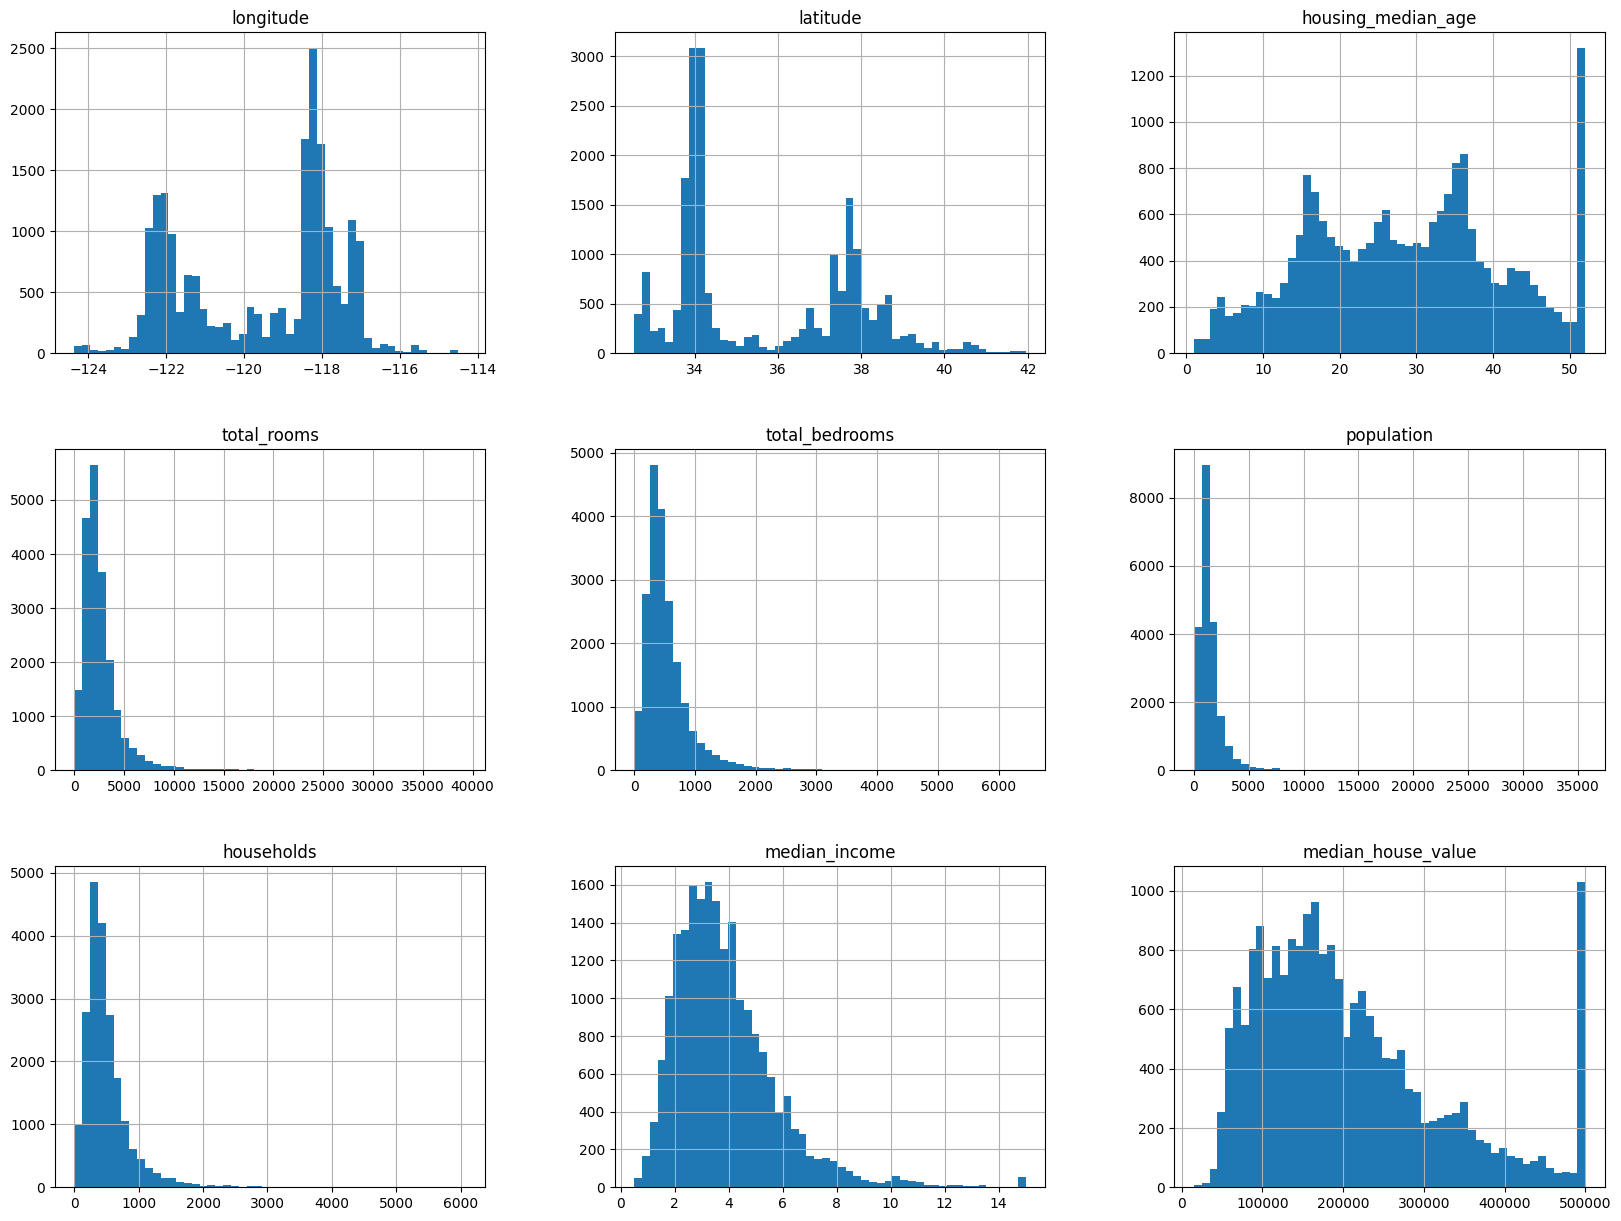

In [8]:
import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize = (20,15)) # Display histograms of the DataFrame's numerical columns
plt.show()  # Show the plot

At a first glance we may note that some attributes are **heavy-tailed**, they differ from the most common value in an asymmetric fashion to the right.this non-campanular shape may be a problem for some machine learning algorithms.

Another thing we have to consider is the measure unit used for the data. Eventually we also have to take into account if some attributes are capped at a specific value or not

## Create a test set
This part is fundamental. We really have to be capabl of assesing the trained model performance somewhere. So we do the following: divide the dataset in two parts, the first bigger one will be used for model training, the second smaller parti for model testing

In this case we take the test set to be equal to the 20% of the original dataset, picking some instances randomly

The following function represents a vanilla versione of already implemented functions within the sci_kit_learn library

In [9]:
def split_train_test(data, test_ratio):
    np.random.seed(42)  # Set a random seed for reproducibility
    shuffled_indices = np.random.permutation(len(data)) # create a randome list of  len(data) indices 
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size] # select indices from shuffle_indices
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices] # return the train and test sets based on the indices
    # the dataframe.iloc[] method is used to select rows and columns by index positions within a DataFrame. 

A simple way of crating the test set is using the train_test_split function from scikit_learn

In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42) # Split the dataset into training and testing sets using sklearn's train_test_split function

train_set.info()
test_set.info()  # Display information about the training and testing sets

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 14196 to 15795
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 4128 entries, 20046 to 3665
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           4128 non-null   float64

Before diving into the real deal methods for test set creation, we may pause and ponder. Is it important how we choose records from the original data set? Yes, in general we have to avoid introducing a sampling bias into the new test and training sets.

For doing so, we make sure to operate a **stratified sampling** over the data. Then, for the housing data, we have to find a discrimant set of attributes to roughly divide the population into classes that, when considered as a whole, represent almost faithfully the original population.

We may consider the *median_income* attribute as a candidate. We add another column to the dataset that encodes this information just for the sake of test set creation and then we remove it

In [11]:
import numpy as np

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5]) # create a new column "income_cat" by binning the "median_income" column into categories using pd.cut()

housing.head()
housing["income_cat"].value_counts()  # Display the value counts of the "income_cat" column

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

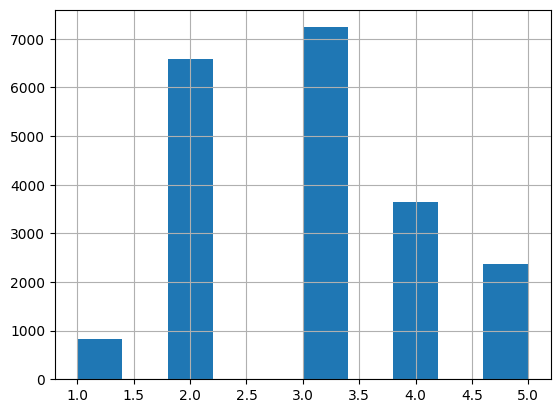

In [12]:
housing["income_cat"].hist()  # Display a histogram of the "income_cat" column
plt.show()  # Show the plot

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
# Create a StratifiedShuffleSplit object to perform stratified sampling

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]): # Split the dataset into training and testing sets using stratified sampling
    # The split.split() method generates indices for the training and testing sets based on the stratified sampling
    strat_train_set = housing.loc[train_index] # Select the training set using the indices
    strat_test_set = housing.loc[test_index] # Select the testing set using the indices

strat_train_set.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,2
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,5
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,2
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,2
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,3


Now we have to remove the added column *income_cat* in order to obtain two pristine datasub-sets from both the training and the test set.

In [14]:
for set_ in (strat_train_set, strat_test_set): # Iterate over the training and testing sets
    set_.drop("income_cat", axis=1, inplace=True)  # Drop the "income_cat" column from both sets
    # The axis=1 parameter specifies that we want to drop a column (not a row), and inplace=True modifies the DataFrame in place without creating a copy.
# The drop() method is used to remove specified labels from rows or columns in a DataFrame.

strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


But do we really need to perform stratified sampling
?
In order to answer this question we have to take a look at the test sets obtained with stratified and non-stratified sampling. The ideal set=up would be the one in which the test set is representative of the whole population

In [15]:
test_set.describe()  # Display descriptive statistics of the training set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,4128.00000,4128.00000,4128.000000,4128.000000,3921.000000,4128.000000,4128.000000,4128.000000,4128.000000
mean,-119.51936,35.58671,28.764293,2610.796269,535.233104,1421.571705,497.750727,3.830338,205500.309593
std,1.99447,2.13276,12.518304,2209.359101,431.299704,1114.023136,387.770570,1.881515,114486.964288
min,-124.19000,32.54000,1.000000,6.000000,2.000000,8.000000,2.000000,0.499900,14999.000000
25%,-121.69000,33.93000,18.000000,1420.000000,294.000000,781.000000,278.000000,2.548500,119275.000000
50%,-118.47000,34.23000,29.000000,2110.000000,428.000000,1160.000000,406.000000,3.500000,178650.000000
75%,-117.99000,37.70000,37.000000,3099.250000,643.000000,1722.000000,598.000000,4.645925,263000.000000
max,-114.58000,41.81000,52.000000,37937.000000,5471.000000,16122.000000,5189.000000,15.000100,500001.000000


In [16]:
strat_test_set.describe()  # Display information about the stratified test set


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,4128.000000,4128.000000,4128.000000,4128.000000,4079.000000,4128.000000,4128.000000,4128.000000,4128.000000
mean,-119.545981,35.602049,28.583818,2688.656250,549.721746,1448.634205,509.651163,3.849818,206257.795058
std,2.010400,2.127889,12.629796,2345.997876,454.528621,1197.164964,407.677609,1.879332,114176.653346
min,-124.180000,32.550000,1.000000,2.000000,1.000000,5.000000,1.000000,0.499900,14999.000000
25%,-121.780000,33.920000,18.000000,1474.000000,301.000000,805.750000,283.000000,2.542675,118900.000000
50%,-118.460000,34.220000,28.000000,2159.500000,442.000000,1172.500000,416.000000,3.513200,181300.000000
75%,-117.980000,37.690000,37.000000,3171.250000,653.000000,1754.250000,613.250000,4.739225,268850.000000
max,-114.560000,41.950000,52.000000,32627.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000


Now that we have created succesfilly a training and test set we want to be sure to set apart the test one and only work with the training set.

In [17]:
housing = strat_train_set.copy()  # Create a copy of the training set for further processing

## Exploratory analysis

### Visualization 
The first crucial step is using the best machine learning tool we know so far: our brai. For doing so we plot the data we have in order to visualize them in a structured way and find key patterns.

<Axes: xlabel='longitude', ylabel='latitude'>

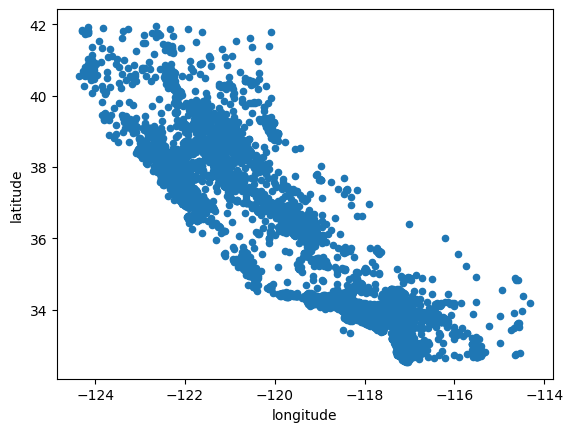

In [18]:
# geographic data
housing.plot(kind = "scatter", x="longitude", y="latitude") # Create a scatter plot of longitude vs latitude

Just by taking a look we recognize that there may be a linear (negative) correlation between longitude and latitude... ormaybe it just ooks like California

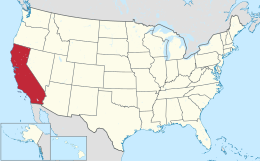

We may want to take a look at high density areas

<Axes: xlabel='longitude', ylabel='latitude'>

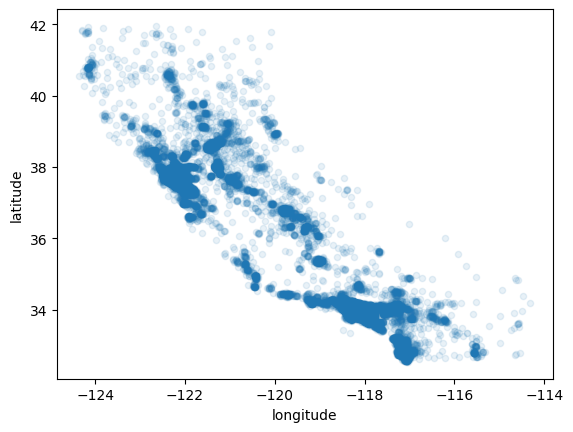

In [19]:
housing.plot(kind = "scatter", x="longitude", y="latitude", alpha = 0.1) # Create a scatter plot with reduced opacity (alpha) to visualize data density
# The alpha parameter controls the transparency of the points in the scatter plot, making it easier to see overlapping points.

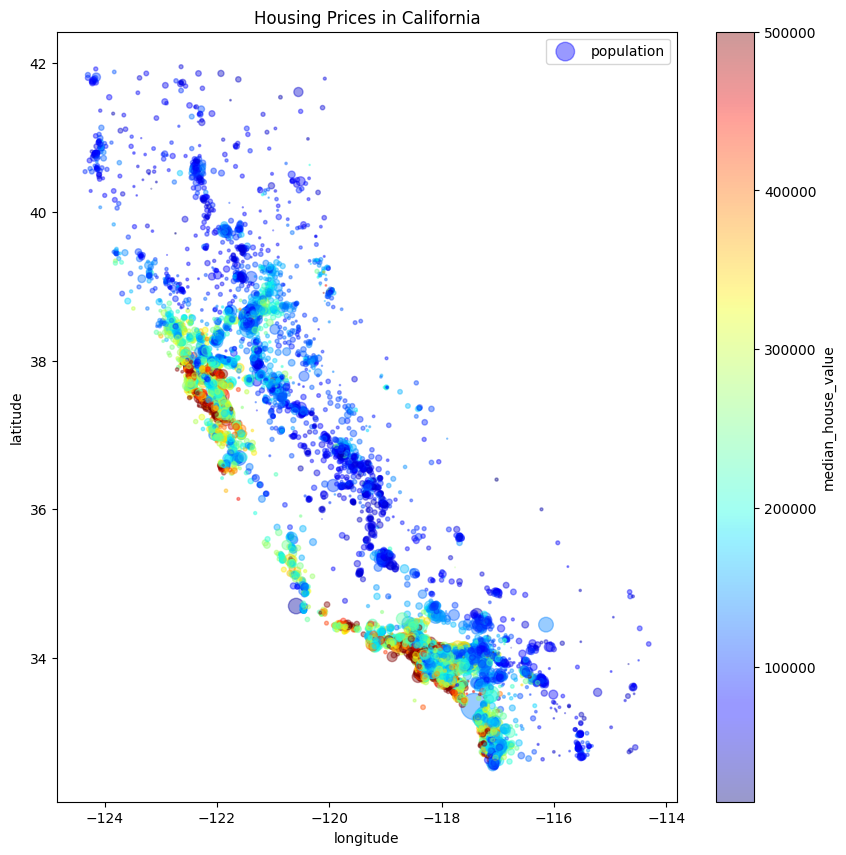

In [20]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4, 
             s = housing["population"]/100, label = "population", figsize = (10,10),
             c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True) # Create a scatter plot with various visual attributes
# The s parameter controls the size of the points based on the population column, and c specifies the color based on median house value.
# The cmap parameter specifies the colormap to use, and colorbar=True adds a color bar to the plot.
# jet is a colormap that ranges from blue to red, with blue representing lower values and red representing higher values.
plt.title("Housing Prices in California")  # Set the title of the plot
plt.legend()  # Display the legend for the plot

### Looking for correlations
In this step we start talking numbers. An easy-to-use and easy-to-compute **linear** correlation measure for this is the *Pearson correaltion coefficient*. In order to compute it:

In [21]:
corr_housing = housing.drop("ocean_proximity", axis=1)  # Drop the "ocean_proximity" column from the DataFrame since it is categorical
corr_matrix = corr_housing.corr()  # Calculate the correlation matrix of the DataFrame between every pair of numerical features
corr_matrix["median_house_value"].sort_values(ascending=False)  # Sort the correlation values with respect to the "median_house_value" column in descending order  

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

We can also take a visual approach to this by using a pandas method that plots every attribute of the data frame against the other ones. Since we would get an enormous matrix, we just consider promising pair of attributes

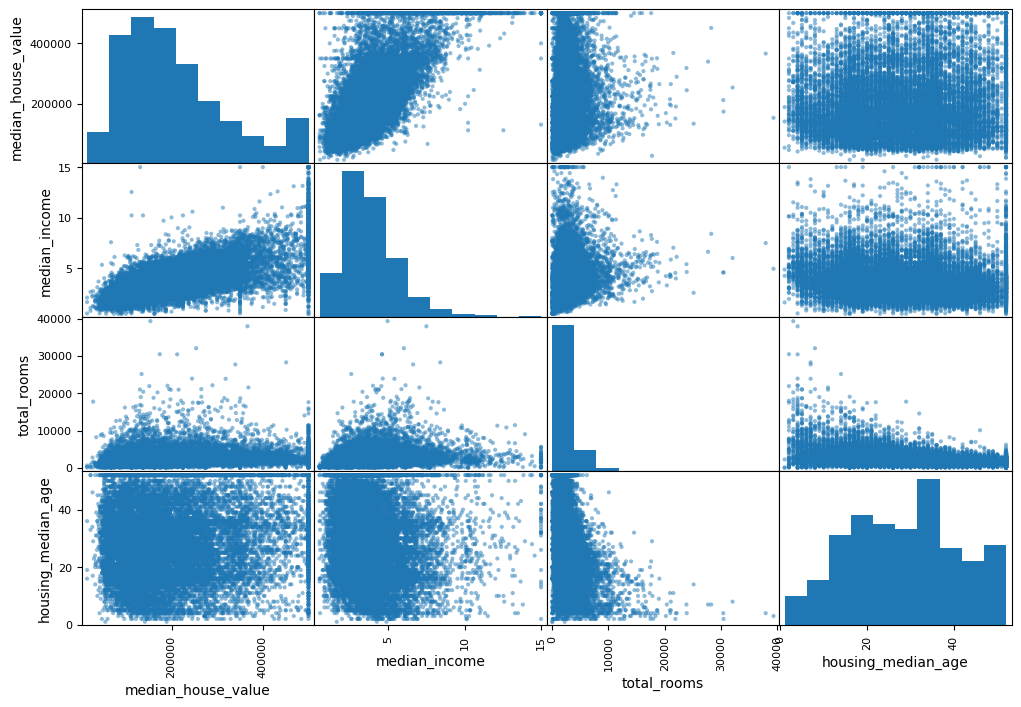

In [22]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]  # Define a list of attributes to plot
scatter_matrix(housing[attributes], figsize=(12, 8))  # Create a scatter matrix plot of the specified attributes
plt.show()  # Show the plot

Let's zoom in on one of the most promising scatter plots

<Axes: xlabel='median_income', ylabel='median_house_value'>

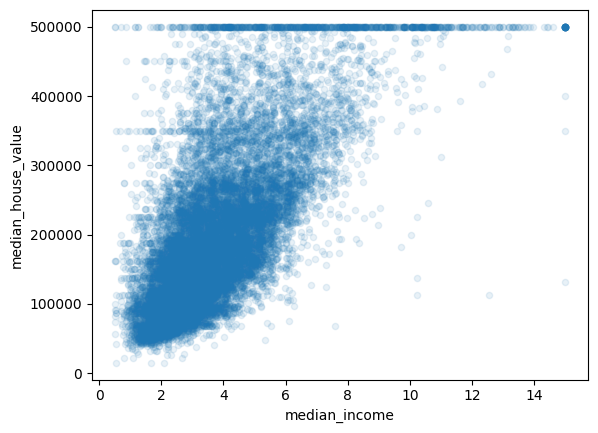

In [23]:
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.1) # Create a scatter plot of median income vs median house value

Interesting insghts:
- there's clearly a strong linear correlation between median_income and median_house_value
- the data cap for median_house_value attribute determines the straight horizontal line at the top
- there are also others non-trivial horizontl lines in the graph (maybe we should try to remove those districts if we want very clear data for the model to train on)

Now that we also have our data visualized we may want to try some interesting variable correlations: 

In [24]:
housing["rooms_per_houesold"] = housing["total_rooms"]/housing["households"]
housing["beedromd_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"] # Create new features based on existing columns

housing.drop("ocean_proximity", axis = 1, inplace = True) # Drop the "ocean_proximity" column from the DataFrame
housing.head()
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)  # Calculate and sort the correlation matrix again after adding new features

median_house_value          1.000000
median_income               0.687151
rooms_per_houesold          0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
beedromd_per_room          -0.259952
Name: median_house_value, dtype: float64

**KEY INSIGHT** This is an iterative process, once you get a good prototype up and running, you can analyze its output to gain more insights and come back to this exploration step

## Prepare the data for machine learning algorithms 
A good idea is implementing these tranformation functions yourself, so that you'll end up builging your personal dataset for preprocessing data. This will allow to have a personal way of dealing with data that could also  be used many times over, granting repetability 

In [25]:
housing = strat_train_set.drop("median_house_value", axis = 1) # for training purposes we suppress the "median_house_value" column, that we want to predict with the model we're up to build 
housing_labels = strat_train_set["median_house_value"].copy()  # Create a copy of the "median_house_value" column as labels for training

#### Dealing with missing data
First things first: how do we deal with missing values in our data? ML algorithms cannot work with issing values and it's our job to work them out of the way. The main approaches are:
- getting rid records with missing values 
- imputing the missing values with a statistica of chioce (median, mean)
- getting rid of all the attribute column with missing values 

In [30]:
# self implementes using Pandas
housing.dropna(subset=["total_bedrooms"])  # Drop rows with missing values in the "total_bedrooms" column
housing.drop("total_bedrooms", axis=1)  # Drop the "total_bedrooms" column from the DataFrame
median = housing["total_bedrooms"].median()  # Calculate the median of the "total_bedrooms" column
housing["total_bedrooms"].fillna(median, inplace = True)

# using Scikit-learn
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(strategy = "median") # Create an imputer object to fill missing values with the median

housing_num = housing.drop("ocean_proximity", axis=1)  # Drop the "ocean_proximity" column from the DataFrame to enable imputation
# median cannot be computed on cateogrial data, so we drop it

imputer.fit(housing_num)  # Fit the imputer to the numerical data to calculate the median values for imputation
imputer.statistics_ # Display the calculated median values for each column
housing_num.median().values  # Display the median values calculated by the imputer and the original DataFrame for comparison

X = imputer.transform(housing_num)
# Transform the numerical data using the fitted imputer to fill missing values with the median
# We get a result in a plain NumPy array, if we want to convert it into a data frame:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index = housing_num.index)
# Create a new DataFrame with the transformed data, using the original column names and indices

C:\Users\bianc\AppData\Local\Temp\ipykernel_12204\3098956780.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing["total_bedrooms"].fillna(median, inplace = True)


#### Dealing with non-numerical data
Algorithms tend to work well with numerical data. But in real life a lot of attributes are non-numerical, just like the ocen_proximity we have in our dataset. How do we work with these values?

In ocean_proximity column, we see that the attribute is a categorical one: we may convert these categories into numbers

In [ ]:
from sklearn.preprocessing import OrdinalEncoder


housing_cat = housing["ocean_proximity"]  # Select the "ocean_proximity" column as categorical data
ordinal_encoder = OrdinalEncoder() # Create an OrdinalEncoder object to encode categorical features
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat) # Fit the encoder to the categorical data and transform it into numerical values

housing_cat_encoded[:10]  
ordinal_encoder.categories_  # Display the categories used for encoding


Thinking a bit about this we may recognize that this king of numerical of encoding in this specific case may not work. Infact there's no a priori order for the categories in the ocean_proximity column, so encoding them numerically may give a false impression of proximity between specific values in the records. 

Another approach would be to creaty come asymmetric dummy variables to replace the catgories. For example, if we have n different categories, we substitute them with n dummy attributes, which are 1 iff the recording falls in the corresponding category. This kind of encoding is calle **hot one** 

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot - cat_encoder.fit_transform(housing_cat)  # Fit the OneHotEncoder to the categorical data and transform it into one-hot encoded format
# the result is a sparse matrix, which is a memory-efficient representation of the one-hot encoded data, which would be an amoungous matrix filled with zeros and just with one 1 per row
housing_cat_1hot.toarray()  # Convert the sparse matrix to a dense array for easier visualization

cat_encoder.categories_  # Display the categories used for one-hot encoding

In general if an attribute covers a lot of different non-ordinal categories it may be a good idea just to substite the attribute with another one, that just gives the same information. Considering the ocean_proximity, we could substitute it with the distance from the sea one 

#### Implenting Custom Transformers
Data analysis is a tailor work. In most of the cases we my have to implement our custom transformers, that have to work along with the SciKitLearn package. For doing this we have to create a class and define three methods: 
1. fit() returning self
2. transform()
3. fit_transform()

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, beedrooms_ix, population_ix, households_ix = 3, 4, 5, 6  # Define the indices of the columns to be transformed

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_beedrooms_per_room-True):
        self.add_beedrooms_per_room = add_beedrooms_per_room
        # this hyperparameter is used to decide whether to add the "beedrooms_per_room" feature or not, seeing if it improves the model performance
    def fit(self, X, y = None):
        return self
        # The fit method is required by the TransformerMixin class, but it doesn't need to do anything in this case, so we just return self.
    def transform(self, X):
        rooms_per_household = X[:,rooms_ix]/X[:, households_ix]
        population_per_household = X[:,population_ix]/X[:, households_ix]
        if self.add_beedrooms_per_room:
            beedrooms_per_room = X[:,beedrooms_ix]/X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, beedrooms_per_room] # Concatenate the new features with the original data
            # np.c_ is used to concatenate arrays along the second axis (columns)
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_beedrooms_per_room=False)  # Create an instance of the CombinedAttributesAdder class with the hyperparameter set to False
housing_extra_attribs = attr_adder.transform(housing.values)  # Transform the housing data using the CombinedAttributesAdder

        

#### Feature Scaling 
A very important transformation is feature scaling. In real life the records show a lot of different attributes with different scales. For example a tension can assume apositive and negative values, while a cost is for definition positive and maybe also capped at some refer value.

ML algorithms work at their best when data have similar scales. For doing we could use two classic feature scaling methods:
1. **min-max scaling** It is easy to implement and very sensible to outliers. It makes so that the all the record ill fall between 0 and 1 $$x' = \frac{x -  \text{min}(x)}{\text{max}(x) - \text{min}(x)}$$ 
2. **standardization** Using the CLT we apply this transform to the data in order to center them at zero and make their variance equals to 1. It doesn't restrict the values in one specific interval and it's not sensible to outliers $$x' = \frac{x - \bar{x}}{\sigma(x)}$$

In [ ]:
from sklearn import MinMaxScaler, StandardScaler

minmax_scaler = MinMaxScaler()  # Create a MinMaxScaler object to scale features to a range between 0 and 1
std_scaler = StandardScaler()  # Create a StandardScaler object to standardize features to have mean 0 and variance 1

housing_num_tr = minmax_scaler.fit_transform(housing_num)  # Scale the numerical data using MinMaxScaler
housing_num_tr = std_scaler.fit_transform(housing_num)  # Standardize the numerical data using StandardScaler   

# the fit_transform() method is used to fit the scaler to the data and then transform it in one step, which is useful for preprocessing data before training a machine learning model.

#### Transformation Pipelines 
Pipelins are a way to save the series of transformation we made to the data in the order we ade them. They are very useful for automatize the process of data preprocessing

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')) # 1. Impute missing values with the median
    ('attribs_adder', CombinedAttributesAdder()), # 2. Add new features using the CombinedAttributesAdder
    ('std_scaler', StandardScaler()), # 3. Standardize the features using StandardScaler
])

# if we want to implement a complete pipeline for both the numerical and categorical features, we can use the ColumnTransformer class from sklearn.compose
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)  # Get the list of numerical attribute names from the DataFrame
cat_attribs = ["ocean_proximity"]  # Define the list of categorical attribute names

full_pipielie = ColumnTransformer([
    ("num", num_pipeline, num_attribs),  # Apply the numerical pipeline to the numerical attributes
    ("cat", OneHotEncoder(), cat_attribs)  # Apply OneHotEncoder to the categorical attributes
    # ("passthrough", "passthrough", ["id"])  # Pass through the "id" column without any transformation
    # ("drop", "drop", ["id"])  # Drop the "id" column from the DataFrame
])

The pipeline and ColumTransforer work in the same way. They have the same methods that are implemented for the **last** implement method. For example, num_pipeline will have the same methods as StandardScaler. Another important costraint is that all the methods in the pipeline except the last one **must** be tranformers (they have to own the fit, transform and fit_transform methods). 

If we want to use the implemented pipeline we just have to use the fit method giving as input the data, then the pipeline apply a fit_transform() to the data with all the transformers except the last method and feeds the result to the next method. When the pipeline reach the last method, there we caled method is applied to the data, so if we called a fit() the last method is fitted on the data. 

In the case of num_pipeline since the last method is a transformer it has the fit_transform() method, so we may call this directly from the pipeline 

In [ ]:
# using the pipeline to transform the data
housing_prepared = full_pipeline.fit_transform(housing)  # Fit the full pipeline to the housing data and transform it

## Select and Train a model
pg 72